## PART II. Data Cleaning

### Objective

Based strictly on the conclusions established in **PART I: Data Profiling and Preprocessing Decisions**,  
this section implements the data cleaning pipeline.

All cleaning operations follow a **governance-driven strategy**, where:
- Missing value handling is guided by missingness categories,
- Format issues are corrected without altering semantic meaning,
- Systematic missingness is preserved as informative signal,
- Over-cleaning and unjustified assumptions are avoided.

The cleaned dataset will serve as the input for **Part III: Feature Engineering**.

### Cleaning Principles Derived from Part I

| Missing Category | Interpretation | Cleaning Strategy |
|-----------------|---------------|------------------|
| Fully missing | No usable information | Drop feature |
| Systematic missing | Meaningful absence | Preserve missing values |
| Moderate missing | Informative but incomplete | Type-aware, selective imputation |
| Low missing | Minor data loss | Conservative imputation |

This separation ensures consistency with the CRISP-DM framework and prevents semantic distortion.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set(style="whitegrid")

# Load raw dataset
df = pd.read_csv("../data/listings.csv")

print("Initial dataset shape:", df.shape)


Initial dataset shape: (3693, 79)


### Duplicate Verification

According to **Part I**, no fully duplicated rows or duplicated listing IDs were detected.
This step is included for verification and documentation consistency only.
No deduplication is performed.


Duplicated rows: 0
Duplicated listing IDs: 0


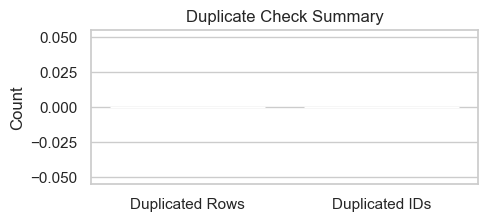

In [3]:
dup_rows = df.duplicated().sum()
dup_ids = df["id"].duplicated().sum()

print("Duplicated rows:", dup_rows)
print("Duplicated listing IDs:", dup_ids)

plt.figure(figsize=(5, 2))
sns.barplot(x=["Duplicated Rows", "Duplicated IDs"], y=[dup_rows, dup_ids])
plt.title("Duplicate Check Summary")
plt.ylabel("Count")
plt.show()


### Removal of Fully Missing Features

The following feature was identified in Part I as **100% missing** and contains no usable information:

- `calendar_updated`

As a result, this feature is removed from the dataset.

In [4]:
df = df.drop(columns=["calendar_updated"])
print("Removed fully missing feature: calendar_updated")

Removed fully missing feature: calendar_updated


### Data Type Conversion and Format Cleaning

Several variables exhibit format inconsistencies rather than semantic errors.
These are corrected to enable numerical analysis while preserving the original data meaning.

Key cases include:
- `price`: stored as a string with currency symbols,
- percentage-based host response metrics.

In [5]:
df["price"] = (
    df["price"]
    .astype(str)
    .str.replace(r"[\$,]", "", regex=True)
)
df["price"] = pd.to_numeric(df["price"], errors="coerce")

print("Price column converted to numeric.")


Price column converted to numeric.


In [6]:
for col in ["host_response_rate", "host_acceptance_rate"]:
    if col in df.columns:
        df[col] = (
            df[col].astype(str)
            .str.replace("%", "")
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("Host response and acceptance rates parsed.")


Host response and acceptance rates parsed.


### Post-cleaning Price Distribution

As established in Part I, listing prices follow a **long-tailed distribution**.
Extreme values are treated as structural characteristics rather than outliers.

Therefore, no price-based filtering is applied.
A log-scale visualization is used to validate the distribution after parsing.


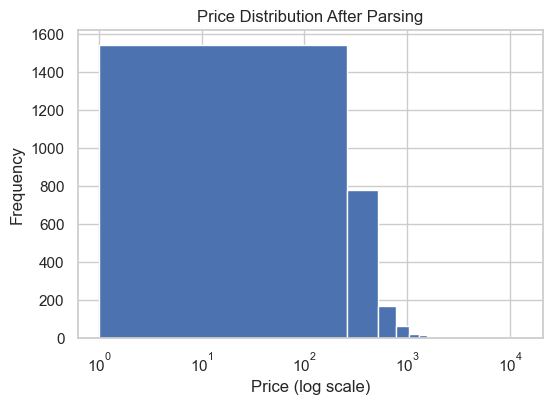

In [7]:
plt.figure(figsize=(6, 4))
df["price"].dropna().hist(bins=50)
plt.xscale("log")
plt.xlabel("Price (log scale)")
plt.ylabel("Frequency")
plt.title("Price Distribution After Parsing")
plt.show()


### Parsing Unstructured Bathroom Information

The `bathrooms` column exhibits moderate missingness.
However, relevant numeric information is embedded in `bathrooms_text`.

A regular-expression-based parser is used to extract the numeric bathroom count.
The original text field is retained.

In [8]:
def parse_bathrooms(text):
    match = re.search(r"(\d+(\.\d+)?)", str(text))
    return float(match.group(1)) if match else np.nan

df["bathrooms"] = df["bathrooms_text"].apply(parse_bathrooms)

df[["bathrooms_text", "bathrooms"]].head()


,bathrooms_text,bathrooms
0,1 private bath,1.0
1,Shared half-bath,NaN
2,Shared half-bath,NaN
3,2 shared baths,2.0
4,2.5 shared baths,2.5


### Missing Values Before Cleaning

This step summarizes missing values in selected variables prior to applying
governance-based imputation strategies.


In [9]:
df[
    ["reviews_per_month", "bedrooms", "beds",
     "host_response_rate", "host_acceptance_rate"]
].isnull().sum()


reviews_per_month       1846
bedrooms                 312
beds                     888
host_response_rate       856
host_acceptance_rate     915
dtype: int64

### Systematic Missingness (Preserved)

Review-related variables and neighborhood descriptions exhibit approximately 50% missingness.
As identified in Part I, this missingness reflects **absence of activity or information**, not data errors.

Accordingly, no imputation is applied to these features at this stage.


### Moderate Missingness Handling

Moderate missing features are handled based on data type and semantic risk:

**Numerical variables**
- Filled using median values to reduce sparsity while remaining robust to skewness.

**Textual or identifier variables**
- Filled with explicit placeholders (e.g., `"Unknown"`) to distinguish missingness from valid values.

Derived metrics (e.g., revenue estimates) are left unimputed.


In [10]:
# Numeric moderate missing
numeric_moderate = ["beds", "host_response_rate", "host_acceptance_rate"]
for col in numeric_moderate:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Text moderate missing
text_moderate = {
    "license": "Unknown",
    "host_location": "Unknown",
    "host_about": "Not provided",
    "host_response_time": "Unknown"
}
for col, val in text_moderate.items():
    if col in df.columns:
        df[col] = df[col].fillna(val)


### Low Missingness Handling

Features with low missing rates (<20%) are handled conservatively:

- Numerical variables: median imputation
- Categorical variables: explicit `"Unknown"` category

This minimizes data loss while avoiding strong assumptions.


In [11]:
# Numeric low missing
for col in df.select_dtypes(include=["int64", "float64"]).columns:
    if df[col].isnull().mean() < 0.2:
        df[col] = df[col].fillna(df[col].median())

# Categorical low missing
for col in df.select_dtypes(include=["object"]).columns:
    if df[col].isnull().mean() < 0.2:
        df[col] = df[col].fillna("Unknown")


### Post-cleaning Missingness Audit

A final audit is conducted to ensure that:
- Fully missing features are removed,
- Systematic missingness is preserved,
- Moderate and low missingness is handled consistently.


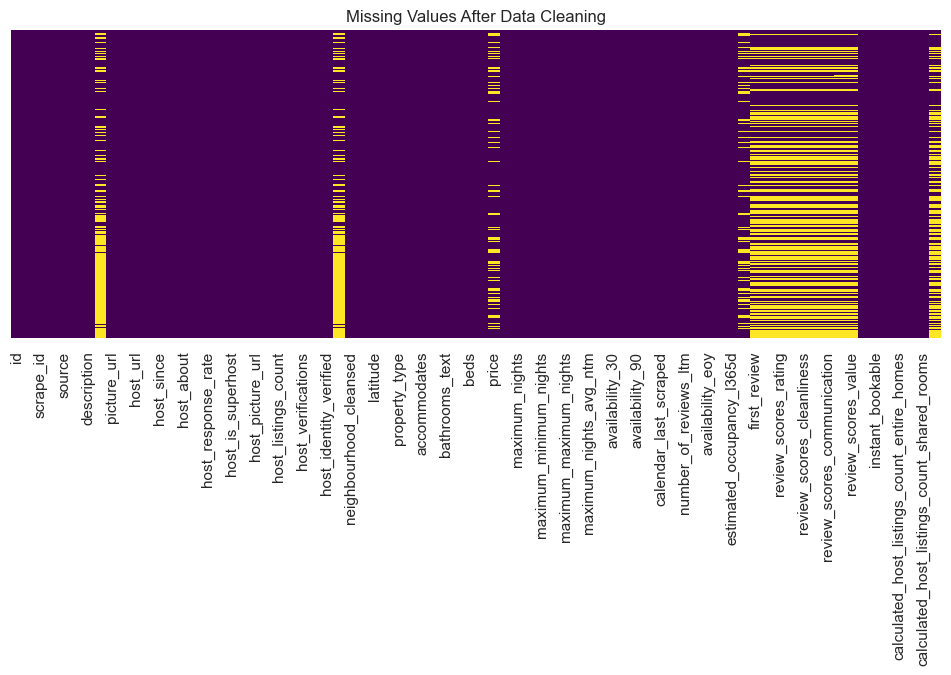

In [14]:
plt.figure(figsize=(12, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis') 
plt.title("Missing Values After Data Cleaning")
plt.show()


### Output

The cleaned dataset is saved and used as input for **Part III: Feature Engineering**.


In [13]:
df.to_csv("../data/listings_cleaned.csv", index=False)
print("✅ listings_cleaned.csv saved successfully.")


✅ listings_cleaned.csv saved successfully.
